In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
#nltk.download () # Download only required or all -> press d, type all, type quit after
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [2]:
train_path = "content/training.csv"
val_path = "content/validation.csv"
test_path = "content/test.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

<BarContainer object of 6 artists>

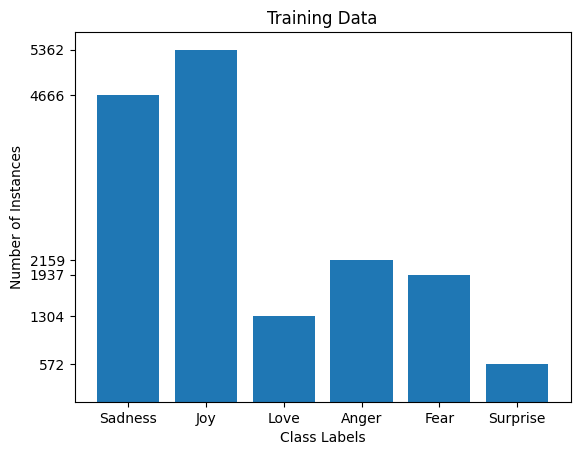

In [3]:
sadness = train_df[train_df['label'] == 0]
joy = train_df[train_df['label'] == 1]
love = train_df[train_df['label'] == 2]
anger = train_df[train_df['label'] == 3]
fear = train_df[train_df['label'] == 4]
suprise = train_df[train_df['label'] == 5]

x = ["Sadness", "Joy", "Love", "Anger", "Fear", "Surprise"]
y = [len(sadness), len(joy), len(love), len(anger), len(fear), len(suprise)]

plt.yticks(y)
plt.xlabel("Class Labels")
plt.ylabel("Number of Instances")
plt.title("Training Data")
plt.bar(x,y)

Tokenization method to tokenize our datasets

In [4]:
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]  

In [5]:
train_df['tokenized'] = train_df.apply(lambda x: tokenize(x['text']), axis=1)
val_df['tokenized'] = val_df.apply(lambda x: tokenize(x['text']), axis=1)
test_df['tokenized'] = test_df.apply(lambda x: tokenize(x['text']), axis=1)

print(train_df['tokenized'])

0                             [i, didnt, feel, humiliated]
1        [i, can, go, from, feeling, so, hopeless, to, ...
2        [im, grabbing, a, minute, to, post, i, feel, g...
3        [i, am, ever, feeling, nostalgic, about, the, ...
4                                [i, am, feeling, grouchy]
                               ...                        
15995    [i, just, had, a, very, brief, time, in, the, ...
15996    [i, am, now, turning, and, i, feel, pathetic, ...
15997                [i, feel, strong, and, good, overall]
15998    [i, feel, like, this, was, such, a, rude, comm...
15999    [i, know, a, lot, but, i, feel, so, stupid, be...
Name: tokenized, Length: 16000, dtype: object


In [6]:
lmtzr = WordNetLemmatizer()
train_df['lemmatized'] = train_df['tokenized'].apply(
                    lambda lst:[lmtzr.lemmatize(word) for word in lst])
val_df['lemmatized'] = val_df['tokenized'].apply(
                   lambda lst:[lmtzr.lemmatize(word) for word in lst])
test_df['lemmatized'] = test_df['tokenized'].apply(
                   lambda lst:[lmtzr.lemmatize(word) for word in lst])

Stemming

In [7]:
stemmer = SnowballStemmer("english")
train_df['stemmed'] = train_df.lemmatized.map(lambda l: [stemmer.stem(word) for word in l])
train_df.stemmed = train_df.stemmed.str.join(sep=' ')

val_df['stemmed'] = val_df.lemmatized.map(lambda l: [stemmer.stem(word) for word in l])
val_df.stemmed = val_df.stemmed.str.join(sep=' ')

test_df['stemmed'] = test_df.lemmatized.map(lambda l: [stemmer.stem(word) for word in l])
test_df.stemmed = test_df.stemmed.str.join(sep=' ')

Preprocessing...

In [8]:
cv = CountVectorizer(stop_words='english')
train_ppd_df = cv.fit_transform(train_df["stemmed"])
val_ppd_df = cv.transform(val_df["stemmed"])
test_ppd_df = cv.transform(test_df["stemmed"])


display(train_ppd_df)
display(val_ppd_df)
display(test_ppd_df)

<16000x10082 sparse matrix of type '<class 'numpy.int64'>'
	with 136700 stored elements in Compressed Sparse Row format>

<2000x10082 sparse matrix of type '<class 'numpy.int64'>'
	with 16253 stored elements in Compressed Sparse Row format>

<2000x10082 sparse matrix of type '<class 'numpy.int64'>'
	with 16432 stored elements in Compressed Sparse Row format>

In [9]:
train_labels = np.array(train_df['label'])
val_labels = np.array(val_df['label'])
test_labels = np.array(test_df['label'])

Now training our model with Multinomial Naive Bayes and testing the accuracy with validation data

In [10]:
mnb = MultinomialNB()
mnb.fit(train_ppd_df,train_labels)
val_predictions_NB = mnb.predict(val_ppd_df)

print("Accuracy Score -> ",accuracy_score(val_predictions_NB, val_labels)*100)
confusion_matrix(y_true=val_labels, y_pred=val_predictions_NB)

Accuracy Score ->  78.4


array([[512,  25,   0,   6,   6,   1],
       [ 40, 647,   5,   8,   4,   0],
       [ 29,  77,  68,   3,   1,   0],
       [ 45,  33,   2, 188,   7,   0],
       [ 35,  24,   0,   7, 144,   2],
       [ 29,  32,   1,   1,   9,   9]])

Now testing the accuracy with test data

In [11]:
predictions_NB = mnb.predict(test_ppd_df)

print("Accuracy Score -> ",accuracy_score(predictions_NB, test_labels)*100)
confusion_matrix(y_true=test_labels, y_pred=predictions_NB)

Accuracy Score ->  77.55


array([[528,  38,   2,   8,   5,   0],
       [ 22, 653,   8,   7,   5,   0],
       [ 27,  76,  51,   4,   1,   0],
       [ 58,  30,   0, 180,   7,   0],
       [ 49,  29,   0,   9, 137,   0],
       [ 16,  33,   0,   1,  14,   2]])